# Laguna Lake Salinity prediciton using a neural net
Laguna Lake is one of the largest freshwater lakes in southeast asia and is posed to become a source of drinking water for the groing population of Manila, The Philippines. Salinity intrusion is a threat to the quality of drinking water in this region, and numerical models have been applied to estimate the magnitude and timing of the intrusion events. However, this intrusion relies on accurate bathymetric/topographic information in the Pasig River, the water way that connects the lake to the ocean. As this information is uncertain, a machine learning based approach for predicting salinity intrusion is tested and compared to the numerical model solution.

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import keras
import matplotlib.pyplot as plt
import os
import inspect
import glob
import datetime
%matplotlib inline
sns.set()

In [67]:
model2fieldloc = {
'Pagsanjan':'PagsanjanStn18_2012-2016',
'Sanctuary':'SanctuaryStn17_2012-2016',
'West Bay' : 'WestBay_Stn1_1999-2016',
'East Bay' : 'EastBayStn2_1999-2016',
'Central B' :'CentralBayStn4_1999-2016',
'West Bay Pasi' : 'WestBayStn5_1999-2016',
'South Bay': 'SouthBayStn8_1999-2016',
'San Pedro' : 'SanPedroStn15_2012-2016',
'Sta. Rosa': 'SanRosaStn16_2012-2016'}

model2fieldsub = {'OXY' : 'DO2M',
                  'NH4' : 'NH3',
                  'NO3' : 'NO3',
                  'PO4' : 'PO4',
                  'Cl'  : 'CL',
                  'SS'  : 'TSS',
                  'BOD' : 'BOD',
                  'COD' : 'COD',
                  'TP'  : 'TP',
                  'TN'  : 'TN',
                  'ALKA': 'ALK'}


In [68]:
def MakeTS(var):
    return pd.Timestamp(var) 

def numRemove(varagin):
    newStr = ''
    for ii in varagin:
        if isnum(ii) or ii == "(" or ii == ")" or ii == "-":
            pass
        else:
            newStr = newStr + ii
    return newStr.strip()

def isnum(varagin):
    try:                    
        float(varagin)
        return True
    except ValueError:
        return False

# Settings

In [69]:
# number of retrospective periods for ANN data
backlog = 0
# length of retrospective periods (days)
interval = 7

# timestep for RNN (days)
ts = 70

station = 'WestBay_Stn1_'

method = 'RNN'

# Feature engineering
For this application we will process a number of features. Only some of these will be used in the final model
* Salinity (the target)
* Water level of the sea, representing the daily average height. This in some way normalizes for tides, and extracts a seasonal fluctuation
* Water level of the lake

Although we would like to include rainfall, the time series is not long enough. Additionally, river inflow is only from 2004-2016, and reduces the amount of data we have.


**Water quality (salinity)**

In [70]:
excelFile = '../data/water_quality/Water_Quality_data_LLDA_v2_1999_2016.xlsx'

datFile = pd.ExcelFile(excelFile)
sheets = datFile.sheet_names
dft = pd.DataFrame()

# collect all locations
for sheet in sheets:
    if 'Figures' not in sheet and 'PrimProd' not in sheet:
        dff = pd.read_excel(excelFile, sheetname = sheet)
        dff = dff[['Salinity (Chloride)','Date']]
        dff.rename(columns = {'Salinity (Chloride)' : 'Salinity ' + sheet}, inplace = True)
        dff.rename(columns = {'Date' : 'date'}, inplace = True)
        dff.set_index('date',inplace = True)
        dff.replace('-',np.nan, inplace = True)
        dff = dff[~dff.index.duplicated(keep='first')]
        dft = pd.concat([dff,dft], axis = 1, ignore_index = False)

dff = dft.copy()

In [71]:
dff

,Salinity PagsanjanStn18_2012-2016,Salinity SanctuaryStn17_2012-2016,Salinity SanRosaStn16_2012-2016,Salinity SanPedroStn15_2012-2016,Salinity SouthBayStn8_1999-2016,Salinity EastBayStn2_1999-2016,Salinity CentralBayStn4_1999-2016,Salinity WestBay_Stn1_1999-2016,Salinity WestBayStn5_1999-2016
date,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-12,NaN,NaN,NaN,NaN,376.0,357.0,673.0,584.0,610.0
1999-02-09,NaN,NaN,NaN,NaN,461.0,372.0,640.0,558.0,536.0
1999-03-09,NaN,NaN,NaN,NaN,491.0,353.0,573.0,536.0,510.0
1999-04-06,NaN,NaN,NaN,NaN,305.0,327.0,571.0,536.0,513.0
1999-05-11,NaN,NaN,NaN,NaN,439.0,205.0,532.0,469.0,454.0
1999-06-22,NaN,NaN,NaN,NaN,439.0,365.0,476.0,443.0,424.0
1999-07-13,NaN,NaN,NaN,NaN,428.0,394.0,439.0,476.0,383.0
1999-08-10,NaN,NaN,NaN,NaN,357.0,175.0,342.0,212.0,368.0


In [72]:
dff.to_csv('../data/LagunaLake_salinity.csv')

**Meteo**

In [73]:
###########################################################################

meteo = '../data/hydrology/Meteo and Streamflow Data/Luzon Meteo Data - PAGASA.xlsx'
meteoFile = pd.ExcelFile(meteo)

locs = ['NAIA (MIA)','AMBULONG']
dfm  = pd.DataFrame()

for ll in locs:
    metDat = pd.read_excel(meteo, sheetname = ll)
    metDat['Date'] = pd.Series()
    for ii,yy in enumerate(metDat['YEAR']):
        metDat['Date'] = pd.to_datetime(metDat[['YEAR','MONTH','DAY']])

    metDat.set_index('Date',inplace = True)
    metDat[metDat['RAINFALL'] == -2] = np.nan
    metDat[metDat['RAINFALL'] == 'T'] = np.nan
    dfm = pd.concat([dfm,metDat['RAINFALL']], axis = 1)
    dfm.rename(columns={'RAINFALL' : (('Rainfall %s [mm]') % ll)}, inplace = True)
    dff = pd.concat([dff,dfm[(('Rainfall %s [mm]') % ll)]], axis = 1)

**Hydological**

In [100]:
###########################################################################

excelFile = '../data/hydrology/Lake Level binary.csv'
dfw = pd.read_csv(excelFile)
dfw['date'] = dfw['date'].apply(MakeTS)
dfw.set_index('date', inplace = True)
dfw['water level (lake) [m]'] = dfw['Water Level'] - 10.47
dfw.replace('-',np.nan, inplace = True)

csvfile = '../data/waterlevel/manila_south_harbor_predic.csv'
dfo = pd.read_csv(csvfile)  
dfo['water level (ocean) [m]'] = dfo['water level [m]']
dfo['time'] = dfo['time'].apply(MakeTS)
dfo.rename(columns = {'time' : 'date'}, inplace = True)
dfo.set_index('date', inplace = True)

df = pd.concat([dfo,dfw], axis = 1)

df = pd.concat([df,dff], axis = 1, ignore_index = False)

###########################################################################
for file in glob.glob(r'../data\hydrology\Meteo and Streamflow Data\*.csv'):
    dff = pd.read_csv(file)
    dff['date'] = dff['date'].apply(MakeTS)
    dff.set_index('date', inplace = True)  
    df = pd.concat([df,dff], axis = 1, ignore_index = False)

Text(0.5,1,'target variable and main forcing')

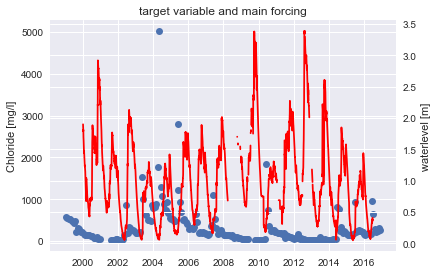

In [101]:
fig = plt.figure(1)
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])        
ax1.plot(df['Salinity ' + station + '1999-2016'], 'o')
ax2 = ax1.twinx()
ax2.plot(df['water level (lake) [m]'], 'r')
ax1.set_ylabel('Chloride [mg/l]')
ax2.set_ylabel('waterlevel [m]')
plt.title('target variable and main forcing')

In [102]:
df.columns

Index(['water level [m]', 'water level (ocean) [m]', 'Water Level',
       'water level (lake) [m]', 'Salinity PagsanjanStn18_2012-2016',
       'Salinity SanctuaryStn17_2012-2016', 'Salinity SanRosaStn16_2012-2016',
       'Salinity SanPedroStn15_2012-2016', 'Salinity SouthBayStn8_1999-2016',
       'Salinity EastBayStn2_1999-2016', 'Salinity CentralBayStn4_1999-2016',
       'Salinity WestBay_Stn1_1999-2016', 'Salinity WestBayStn5_1999-2016',
       'Angono', 'Baras', 'Binan', 'Calauan', 'Caliraya', 'Jala jala',
       'Los Banos', 'Mangahan', 'Marikina', 'Morong', 'Muntinlupa', 'Palilla',
       'Pangil', 'Pasanjan', 'Pila', 'San Cristobal', 'San Juan', 'San Pedro',
       'Siniloan', 'Sta. Cruz', 'Sta. Maria', 'Sta. Rosa', 'Taguig', 'Tanay'],
      dtype='object')

**Create week delays for the ANN**

In [103]:
###########################################################################
# create week delays
df.rename(columns = {'water level (ocean) [m]' : 'ocean'}, inplace = True)
df.rename(columns = {'water level (lake) [m]' : 'lake'}, inplace = True)
df = df[df.index.isnull() == False]
lake = {}
if method == 'ANN':
    for ii in range(1,backlog + 1):
        lake['lake' + str(ii)] = []
    for ind,dw in enumerate(df['lake']):
        for ii in range(1,backlog + 1):
            # create each staggered array if index is larger than the distance back you will search
            if ind > (interval*ii)-2 and ind < len(df['lake'])- (interval*ii) - 1:
                lake['lake'+ str(ii)].append([df['lake'].iloc[ind-interval*ii],df['lake'].index[ind]])
            else:
                lake['lake'+ str(ii)].append([np.nan,df['lake'].index[ind]])

    for ii in range(1,backlog + 1):
        tmp = pd.DataFrame(np.array(lake['lake' + str(ii)]))
        tmp.set_index(1,inplace = True)
        tmp.rename(columns = {0 : 'lake' + str(ii)}, inplace = True)
        df = pd.concat([df,tmp],  axis = 1)

**Interpolate salinity signal so that daily values are available**

In [104]:
###########################################################################        
# interpolate salinity data
# looped because interval between measurements is not constant
# how many values to insert? 
# div = 3

ldat = df[df['Salinity WestBay_Stn1_1999-2016'].isnull() == False].index
# indicies of valid measurements
tind = [ind for ind,ll in enumerate(df.index) if ll in ldat]
for col in df.columns:
    df[col].replace('*', np.nan,inplace = True)

for ind, time in enumerate(ldat):
    # for each safe location
    if ind > 0:
        # if not the first location
        for col in df.columns: # interpolate for all columns
            v2 = df[col].iloc[tind[ind]]
            v1 = df[col].iloc[tind[ind-1]]
            # choose the indicies that break the interval into the desired steps
            # inter = int(np.floor((tind[ind] - tind[ind-1])/(div+1)))
            inter = 1
            if inter != 0:
                x = np.arange(tind[ind-1],tind[ind],inter)
                arr = np.interp(x,[tind[ind-1],tind[ind]],[v1,v2])
                df[col].iloc[x] = arr 

In [105]:
df.to_csv('../data/LagunaLake_clean.csv')

# Load and filter as needed
* in this step the desired features are chosen

In [107]:
file = '../data/LagunaLake_clean.csv'
df = pd.read_csv(file)
df['date'] = df['date'].apply(MakeTS)
df.set_index('date',inplace = True)
max_dict = {}
for cind, col in enumerate(df.columns):
    if 'water' in col or station in col or 'lake' in col or 'ocean' in col or cind >=14:
        # normalize
        # df[col] = (df[col] - df[col].mean()) / df[col].std()
        max_dict[col] = df[col].max()
        df[col] = df[col] / df[col].max()
        print('adding ' + col)
    else:
        df.drop(col, axis = 1, inplace = True)

df.dropna(axis = 0, inplace = True)

adding water level [m]
adding ocean
adding lake
adding Salinity WestBay_Stn1_1999-2016
adding Baras
adding Binan
adding Calauan
adding Caliraya
adding Jala jala
adding Los Banos
adding Mangahan
adding Marikina
adding Morong
adding Muntinlupa
adding Palilla
adding Pangil
adding Pasanjan
adding Pila
adding San Cristobal
adding San Juan
adding San Pedro
adding Siniloan
adding Sta. Cruz
adding Sta. Maria
adding Sta. Rosa
adding Taguig
adding Tanay


In [108]:
df.describe()


,water level [m],ocean,lake,Salinity WestBay_Stn1_1999-2016,Baras,Binan,Calauan,Caliraya,Jala jala,Los Banos,...,Pila,San Cristobal,San Juan,San Pedro,Siniloan,Sta. Cruz,Sta. Maria,Sta. Rosa,Taguig,Tanay
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,...,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,-0.016395,-0.016395,0.321391,0.068456,0.028150,0.021224,0.032823,0.056955,0.031762,0.022909,...,0.038702,0.021414,0.021258,0.021705,0.055527,0.035579,0.041377,0.022073,0.020178,0.031309
std,0.548495,0.548495,0.207242,0.100597,0.086644,0.081977,0.092421,0.113500,0.089126,0.083657,...,0.096309,0.083605,0.083395,0.082147,0.111543,0.089365,0.097380,0.082733,0.079622,0.088573
min,-0.851708,-0.851708,0.019175,0.003644,0.000636,0.000440,0.001344,0.003728,0.001394,0.000880,...,0.001511,0.000510,0.000518,0.000354,0.003215,0.001438,0.002077,0.000448,0.000274,0.001212
25%,-0.551737,-0.551737,0.153281,0.011903,0.001369,0.000876,0.002681,0.007884,0.002909,0.001770,...,0.003073,0.001098,0.001145,0.000730,0.007608,0.002972,0.004790,0.000881,0.000503,0.002723
50%,-0.047286,-0.047286,0.288855,0.037962,0.002332,0.001437,0.007113,0.021130,0.005384,0.002708,...,0.009601,0.001690,0.001709,0.001305,0.017099,0.012011,0.011060,0.001412,0.000838,0.004517
75%,0.473661,0.473661,0.433556,0.083689,0.020215,0.010709,0.025070,0.055044,0.025477,0.010777,...,0.035917,0.008891,0.007512,0.011924,0.056127,0.030279,0.035981,0.013063,0.010827,0.023782
max,0.976595,0.976595,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# ANN - ignore for now

In [ ]:
target = df.pop([ii for ii in df. columns if station in ii][0])

df = df[[ii for ii in df.columns if 'lake' in ii].append('ocean')]
model = keras.Sequential()
model.add(keras.layers.Dense(2 * len(df.columns), input_dim = len(df.columns), activation = 'tanh'))
model.add(keras.layers.Dense(2 * len(df.columns), activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'relu'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy', 'loss'])

history = model.fit(df, target,  epochs=100, batch_size=50)

# RNN

In [109]:
# X must be of dim (samples, time steps, features)
# rainfall series is not long enough to include
target = df.pop([ii for ii in df. columns if station in ii][0])

X = np.array(df)
X = np.reshape(X, (1, X.shape[0], X.shape[1]))
# memory size
X_l = np.zeros((X.shape[1] , ts, len(df.columns))) * np.nan
Y_l = np.zeros((X.shape[1])) * np.nan
# create timesteps array
for time in range(0, X_l.shape[0]):
    if time < ts-1:
        pass
    else:

        X_l[time,:,:] = X[0, (time+1-ts):time+1, :]

        # time at 60 will be the 61st number, and will not line up. Thus we take the 60th number at index 59
        Y_l[time] = target[time]
        
# clip the skipped part
X_l = X_l[ts-1:,:,:]
Y_l = Y_l[ts-1:]
pred_time = df.index[ts-1:]

In [110]:
X_l.shape

(4018, 70, 26)

In [111]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape = (X_l.shape[1], X_l.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_l, Y_l , epochs=70)        

Epoch 1/70
4018/4018 [==============================] - 4s 979us/step - loss: 0.0090 - acc: 0.0000e+00
Epoch 2/70
4018/4018 [==============================] - 3s 816us/step - loss: 0.0075 - acc: 0.0000e+00
Epoch 3/70
4018/4018 [==============================] - 3s 845us/step - loss: 0.0076 - acc: 0.0000e+00
Epoch 4/70
4018/4018 [==============================] - 3s 846us/step - loss: 0.0074 - acc: 0.0000e+00
Epoch 5/70
4018/4018 [==============================] - 3s 852us/step - loss: 0.0074 - acc: 0.0000e+00
Epoch 6/70
4018/4018 [==============================] - 3s 847us/step - loss: 0.0070 - acc: 0.0000e+00
Epoch 7/70
4018/4018 [==============================] - 3s 860us/step - loss: 0.0067 - acc: 0.0000e+00
Epoch 8/70
4018/4018 [==============================] - 3s 866us/step - loss: 0.0065 - acc: 0.0000e+00
Epoch 9/70
4018/4018 [==============================] - 3s 859us/step - loss: 0.0076 - acc: 0.0000e+00
Epoch 10/70
4018/4018 [==============================] - 4s 922us/step - 

KeyboardInterrupt: 

# Visualize 

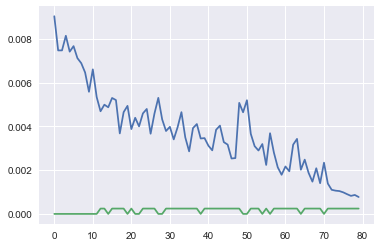

In [141]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

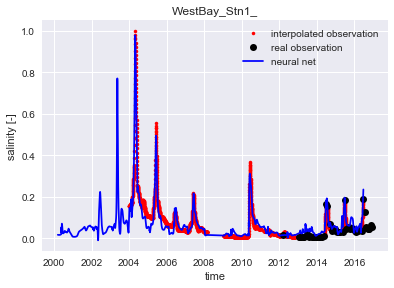

In [142]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])               
ax1.plot(target, 'r.', label = 'interpolated observation')

dff = pd.read_csv('data/LagunaLake_salinity.csv')
dff['date'] = dff['date'].apply(MakeTS)
dff.set_index('date', inplace = True)
plt.plot(dat.index, dat['Salinity WestBay_Stn1_1999-2016'] / max_dict[target.name],'ko', label = 'real observation')

ax1.plot(pred_time, model.predict(X_l), 'b-', label = 'neural net')
ax1.legend()

ax1.set_xlabel('time')
ax1.set_ylabel('salinity [-]')
plt.title(station)
pylab.savefig(station + '.png')

Obviously it is wildly overfit<br>
Remove the rivers, so the time series can be 4 years longer. These earlier years will be used as test data.

In [143]:
df = pd.read_csv(file)
df['date'] = df['date'].apply(MakeTS)
df.set_index('date',inplace = True)
max_dict = {}
for cind, col in enumerate(df.columns):
    if 'water' in col or station in col or 'lake' in col or 'ocean' in col :
        # normalize
        # df[col] = (df[col] - df[col].mean()) / df[col].std()
        max_dict[col] = df[col].max()
        df[col] = df[col] / df[col].max()
    else:
        df.drop(col, axis = 1, inplace = True)

df.dropna(axis = 0, inplace = True)

In [144]:
target = df.pop([ii for ii in df. columns if station in ii][0])

X = np.array(df)
X = np.reshape(X, (1, X.shape[0], X.shape[1]))
# memory size = instances x times per instance x features
X_l = np.zeros((X.shape[1] , ts, len(df.columns))) * np.nan
Y_l = np.zeros((X.shape[1])) * np.nan

# create timesteps array
for time in range(0, X_l.shape[0]):
    if time < ts-1:
        # not enough space to look back at
        pass
    else:

        X_l[time,:,:] = X[0, (time+1-ts):time+1, :]
        # time at 60 will be the 61st number, and will not line up. Thus we take the 60th number at index 59
        Y_l[time] = target[time]
        
# clip the skipped part
X_l = X_l[ts-1:,:,:]
Y_l = Y_l[ts-1:]
pred_time = df.index[ts-1:]

**Train-Test split**

In [113]:
print(len(target))
print(len(Y_l))
target = target.iloc[ts-1:]
ind = np.argmin(abs((target.index - pd.Timestamp('2004-01-01'))))
target.index[ind]
target.index[ind]
X_train = X_l[ind:,:,:]
Y_train = Y_l[ind:]
X_test  = X_l[:ind,:,:]
Y_test  = Y_l[:ind]

4087
4018


In [146]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train , epochs=80)    

Epoch 1/80
4091/4091 [==============================] - 2s 549us/step - loss: 0.0090 - acc: 0.0000e+00
Epoch 2/80
4091/4091 [==============================] - 1s 356us/step - loss: 0.0077 - acc: 0.0000e+00
Epoch 3/80
4091/4091 [==============================] - 1s 356us/step - loss: 0.0078 - acc: 0.0000e+00
Epoch 4/80
4091/4091 [==============================] - 1s 362us/step - loss: 0.0078 - acc: 0.0000e+00
Epoch 5/80
4091/4091 [==============================] - 1s 357us/step - loss: 0.0072 - acc: 0.0000e+00
Epoch 6/80
4091/4091 [==============================] - 2s 384us/step - loss: 0.0063 - acc: 2.4444e-04
Epoch 7/80
4091/4091 [==============================] - 1s 366us/step - loss: 0.0069 - acc: 0.0000e+00
Epoch 8/80
4091/4091 [==============================] - 2s 379us/step - loss: 0.0065 - acc: 0.0000e+00
Epoch 9/80
4091/4091 [==============================] - 2s 373us/step - loss: 0.0061 - acc: 0.0000e+00
Epoch 10/80
4091/4091 [==============================] - 1s 359us/step - 

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

**Evaluate performance on training set**

NameError: name 'Y_train' is not defined

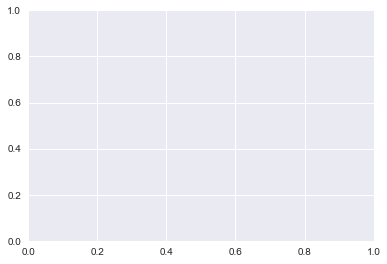

In [112]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])               
ax1.plot(pred_time[ind:], Y_train, 'ro', label = 'observed')
ax1.plot(pred_time[ind:], model.predict(X_train), 'b-', label = 'neural net')
ax1.legend()
#ax1.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2014-01-01')) 

ax1.set_xlabel('time')
ax1.set_ylabel('salinity [-]')
plt.title(station)


**Evaluate using test set**

Text(0.5,1,'WestBay_Stn1_')

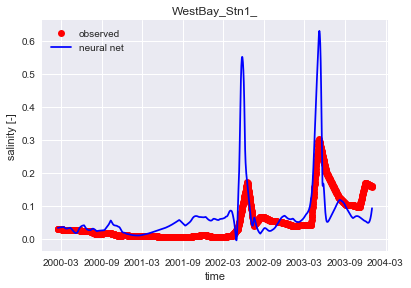

In [150]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])               
ax1.plot(pred_time[:ind], Y_test, 'ro', label = 'observed')
ax1.plot(pred_time[:ind], model.predict(X_test), 'b-', label = 'neural net')
ax1.legend()
#ax1.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2014-01-01')) 

ax1.set_xlabel('time')
ax1.set_ylabel('salinity [-]')
plt.title(station)

# Comparison to numerical model

West Bay-18
Salinity WestBay_Stn1_1999-2016


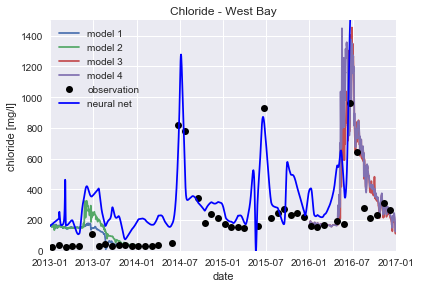

In [151]:
dff = pd.read_csv('data/LagunaLake_salinity.csv')
dff['date'] = dff['date'].apply(MakeTS)
dff.set_index('date', inplace = True)
model11 = pd.read_csv(r'data\LagunaLake\numerical_model\R02\salinity_layer10.csv')
model21 = pd.read_csv(r'data\LagunaLake\numerical_model\G03\salinity_layer10.csv')
model12 = pd.read_csv(r'data\LagunaLake\numerical_model\R08\salinity_layer10.csv')
model22 = pd.read_csv(r'data\LagunaLake\numerical_model\R09\salinity_layer10.csv')
for loc in model1.columns:
    if numRemove(loc) in model2fieldloc.keys():
        if station in model2fieldloc[numRemove(loc)]:
            print(loc)
            dat = dff.copy()
            modTime = []
            for ii,jj in enumerate(model11['Date']):
                # ordinal is not the same convention as in matlab?
                dyy = datetime.datetime.fromordinal(int(np.floor(model11['Date'][ii]))) - datetime.timedelta(days = 365)
                dyfr = model11['Date'][ii] % int(np.floor(model11['Date'][ii]))
                modTime.append(dyy + datetime.timedelta(days = dyfr))
            dat.replace('*', np.nan, inplace = True)
            dat.dropna(inplace = True, axis = 0)
            fig = plt.figure()
            ax = fig.add_axes([0.1,0.1,0.8,0.8])
            # salinity to chloride conversion
            ax.plot(modTime,model11[loc] * 1000 /  1.64846, label = 'model 1')
            ax.plot(modTime,model21[loc] * 1000 /  1.64846, label = 'model 2')
            
            modTime = []
            for ii,jj in enumerate(model12['Date']):
                # ordinal is not the same convention as in matlab?
                dyy = datetime.datetime.fromordinal(int(np.floor(model12['Date'][ii]))) - datetime.timedelta(days = 365)
                dyfr = model12['Date'][ii] % int(np.floor(model12['Date'][ii]))
                modTime.append(dyy + datetime.timedelta(days = dyfr))           
            ax.plot(modTime,model12[loc] * 1000 /  1.64846, label = 'model 3')
            ax.plot(modTime,model22[loc] * 1000 /  1.64846, label = 'model 4')

            print('Salinity ' + model2fieldloc[numRemove(loc)])
            ax.plot(dat.index,dat['Salinity ' + model2fieldloc[numRemove(loc)]],'ko', label = 'observation')
                
            plt.grid

            plt.title('Chloride' + ' - ' + numRemove(loc))
            plt.xlabel('date')
            plt.ylabel('chloride [mg/l]')
            ax.set_ylim([0,1500])

ax.plot(pred_time, model.predict(X_l) * max_dict[target.name], 'b-', label = 'neural net')
ax.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2017-01-01')) 
plt.legend()